# 1. AAL atlas

In [1]:
from src.utils import initialize_experiment

experiment = initialize_experiment()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/etokone/fmri-la5c-study/6b1f8e18e44e4e68aa4cc4ff1d2ed389



In [2]:
import os 

from src.utils import calc_all_sub_ts

from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn import datasets
from bids.layout import BIDSLayout

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

%matplotlib inline

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [3]:
# Base directory for fmriprep output
fmriprep_dir = '../data/ds000030/derivatives/fmriprep/'
layout = BIDSLayout(fmriprep_dir,
                        config=['bids', 'derivatives'])

In [4]:
atlas_aal = datasets.fetch_atlas_aal()

In [5]:
params = {
    'parcel_file': atlas_aal['maps'],
    'confounds': ['trans_x', 'trans_y', 'trans_z', 
                  'rot_x', 'rot_y', 'rot_z', 
                  'white_matter', 'csf', 'global_signal'],
    'high_pass': 0.009,
    'low_pass': 0.08,
    'detrend': True,
    'standardize': True,
    'tr_drop': 4
    
}
experiment.log_parameters(params)

In [6]:
from nilearn import input_data

masker = input_data.NiftiLabelsMasker(labels_img=params['parcel_file'],
                                      standardize=params['standardize'],
                                      memory='nilearn_cache',
                                      detrend=params['detrend'],
                                      low_pass=params['low_pass'],
                                      high_pass=params['high_pass'],
                                      t_r=2)

In [7]:
ctrl_subjects_raw, schz_subjects_raw, labels_list = calc_all_sub_ts(layout, params, masker)

  0%|                                                                                                                                                                                        | 0/17 [00:00<?, ?it/s]/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/input_data/nifti_labels_masker.py:486: UserWarning: Persisting input arguments took 1.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:52<00:00,  3.11s/it]


Control group connectivity matrix shape (7, 116, 116)


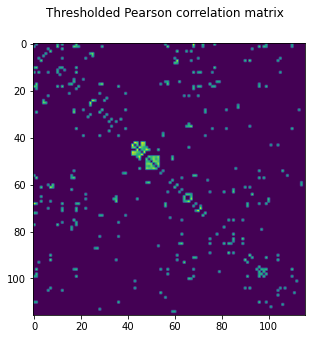

{'web': 'https://www.comet.ml/api/asset/download?assetId=8f1fd993ecb54058a318ec944cb47512&experimentKey=6b1f8e18e44e4e68aa4cc4ff1d2ed389',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=8f1fd993ecb54058a318ec944cb47512&experimentKey=6b1f8e18e44e4e68aa4cc4ff1d2ed389',
 'assetId': '8f1fd993ecb54058a318ec944cb47512'}

In [8]:
from nilearn.connectome import ConnectivityMeasure
from sklearn.covariance import EmpiricalCovariance

covariance_estimator = EmpiricalCovariance()
connectivity_correlation = ConnectivityMeasure(kind="correlation", cov_estimator=covariance_estimator)

# Calculate pearson correlation
R_ctrl = connectivity_correlation.fit_transform(ctrl_subjects_raw)
print(f'Control group connectivity matrix shape {R_ctrl.shape}')

# Tresholding
R_tresholded = R_ctrl[0].copy()
np.fill_diagonal(R_tresholded, 0)
R_tresholded[R_tresholded < 0.5] = 0.0

# Visualise
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
plt.suptitle("Thresholded Pearson correlation matrix")
ax1.imshow(R_tresholded)
plt.show()

experiment.log_confusion_matrix(matrix=R_tresholded)

## Network visualization

In [9]:
# ROIs coordinates
coordinates = nplot.find_parcellation_cut_coords(labels_img=atlas_aal["maps"])

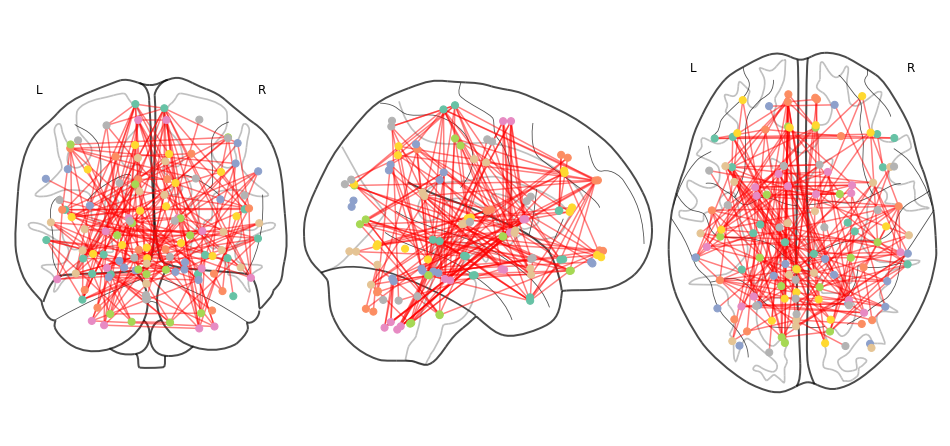

In [10]:
# nilearn graph drawing
fig = plt.figure(figsize=(13,6))
edge_options = {"color": "r", "linewidth": 1.5, "alpha": 0.5}
nplot.plot_connectome(R_tresholded, coordinates, figure=fig, edge_kwargs=edge_options)

In [11]:
import networkx as nx
#import diagram2vec

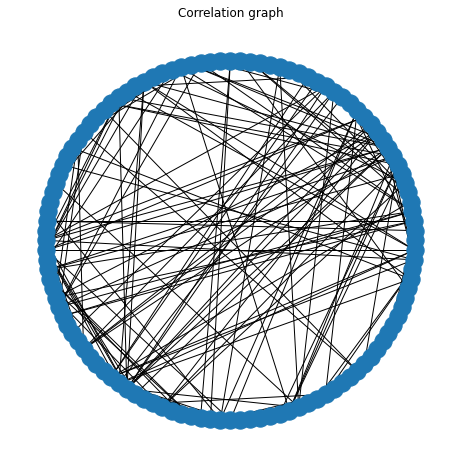

In [12]:
# matplotlib graph drawing
fig, (ax1) = plt.subplots(1, 1, figsize=(8,8))
ax1.set_title("Correlation graph")
nx.draw_shell(nx.from_numpy_array(R_tresholded), ax=ax1)
plt.show()

In [13]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/etokone/fmri-la5c-study/6b1f8e18e44e4e68aa4cc4ff1d2ed389
COMET INFO:   Parameters:
COMET INFO:     confounds   : ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'white_matter', 'csf', 'global_signal']
COMET INFO:     detrend     : True
COMET INFO:     high_pass   : 0.009
COMET INFO:     low_pass    : 0.08
COMET INFO:     parcel_file : /home/neuro/nilearn_data/aal_SPM12/aal/atlas/AAL.nii
COMET INFO:     standardize : True
COMET INFO:     tr_drop     : 4
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (15.53 MB)
COMET INFO:     installed pa